In [1]:
import autoreg
import GPy
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function
%matplotlib inline

from autoreg.benchmark import tasks

In [2]:
# Function to compute root mean square error:

def comp_RMSE(a,b):
    return np.sqrt(np.square(a-b).mean())

In [3]:
# Define class for normalization
class Normalize(object):
    
    def __init__(self, data, name, norm_name):
        
        self.data_mean = data.mean(axis=0)
        self.data_std = data.std(axis=0)
        self.normalization_computed = True
        
        setattr(self, name, data)                         
        setattr(self, norm_name, (data-self.data_mean) / self.data_std )
        
    def normalize(self, data, name, norm_name):
            if hasattr(self,norm_name):
                raise ValueError("This normalization name already exist, choose another one")
            
            setattr(self, name, data )
            setattr(self, norm_name, (data-self.data_mean) / self.data_std )
            
            
                                     
    def denormalize(self, data):
                                   
        return data*self.data_std + self.data_mean    

In [4]:
trainned_models_folder_name = "/Users/grigoral/work/code/RGP/examples/identif_trainded"
task_name = 'Ballbeam'
# task names:
# Actuator, Ballbeam, Drive, Gas_furnace, Flutter, Dryer, Tank,
# IdentificationExample1..5

In [5]:
task = getattr( tasks, task_name)
task = task()
task.load_data()
print("Data OUT train shape:  ", task.data_out_train.shape)
print("Data IN train shape:  ", task.data_in_train.shape)
print("Data OUT test shape:  ", task.data_out_test.shape)
print("Data IN test shape:  ", task.data_in_test.shape)

Data OUT train shape:   (500, 1)
Data IN train shape:   (500, 1)
Data OUT test shape:   (500, 1)
Data IN test shape:   (500, 1)


### Normalize training and test data:

In [6]:
in_data = Normalize(task.data_in_train,'in_train','in_train_norm' )
out_data = Normalize(task.data_out_train,'out_train','out_train_norm' )

in_data.normalize(task.data_in_test, 'in_test','in_test_norm')
out_data.normalize(task.data_out_test, 'out_test','out_test_norm')

out_train = out_data.out_train_norm
in_train = in_data.in_train_norm
out_test = out_data.out_test_norm
in_test = in_data.in_test_norm

print("Training OUT mean:  ", out_train.mean(0)); 
print("Training OUT std:  ", out_train.std(0))
print("")
print("Test OUT mean:  ", out_test.mean(0)); 
print("Test OUT std:  ", out_test.std(0))
print("")
print("Training IN mean:  ", in_train.mean(0)); 
print("Training IN std:  ", in_train.std(0))
print("")
print("Test IN mean:  ", in_test.mean(0)); 
print("Test IN std:  ", in_test.std(0))

Training OUT mean:   [ 0.]
Training OUT std:   [ 1.]

Test OUT mean:   [ 0.53121245]
Test OUT std:   [ 1.03566227]

Training IN mean:   [  4.26325641e-17]
Training IN std:   [ 1.]

Test IN mean:   [-0.08153323]
Test IN std:   [ 1.41568351]


### Plot training and test data:

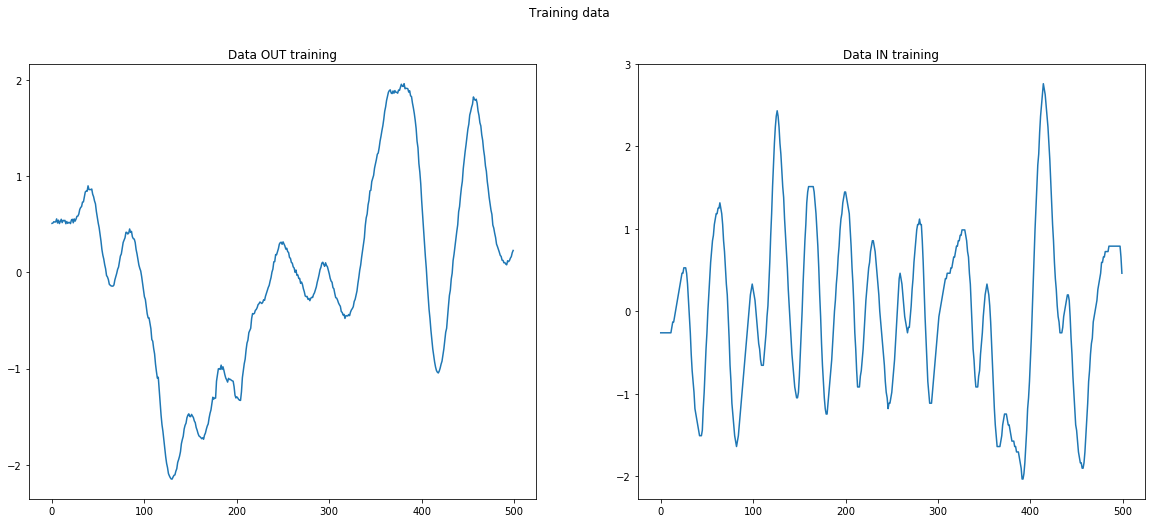

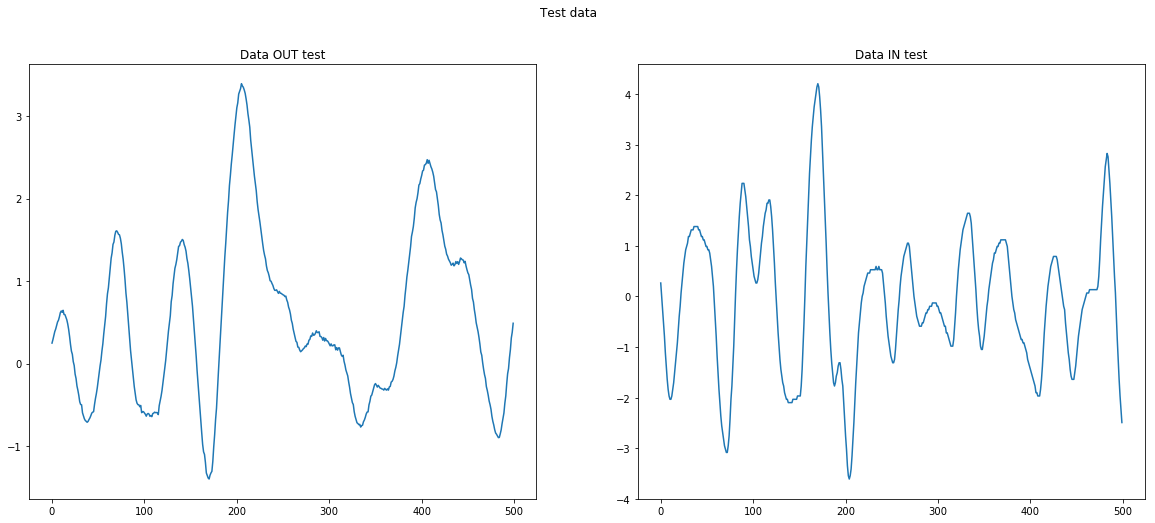

In [7]:
# Plot training:
fig1 = plt.figure(1,figsize=(20,8))
fig1.suptitle('Training data')
ax1 = plt.subplot(1,2,1)
ax1.plot(out_train)
ax1.set_title('Data OUT training')

ax2 = plt.subplot(1,2,2)
ax2.plot(in_train)
ax2.set_title('Data IN training')

fig2 = plt.figure(2,figsize=(20,8))
fig2.suptitle('Test data')
ax3 = plt.subplot(1,2,1)
ax3.plot(out_test)
ax3.set_title('Data OUT test')

ax4 = plt.subplot(1,2,2)
ax4.plot(in_test)
ax4.set_title('Data IN test')

del ax1, ax2, ax3, ax4

### Model definition:

In [22]:
Q = 50 # 200 # Inducing points num
win_in = 20 # task.win_in # 20
win_out = 20 # task.win_out # 20
use_controls = True
back_cstr = False
inference_method = None
wins = [0, win_out] # 0-th is output layer
#wins = [win_out, ] # 0-th is output layer

MLP_dims = [300,200]
nDims = [out_data.out_train_norm.shape[1],1]
print("Input window:  ", win_in)
print("Output window:  ", win_out)


m = autoreg.DeepAutoreg_new(wins, out_data.out_train_norm, U=in_data.in_train_norm, U_win=win_in,
                        num_inducing=Q, back_cstr=back_cstr, MLP_dims=MLP_dims, nDims=nDims,
                        init='rand', # how to initialize hidden states means
                        X_variance=0.01, # how to initialize hidden states variances
                        inference_method=inference_method, # Inference method
                        kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True),
                                 GPy.kern.RBF(win_in + win_out,ARD=True,inv_l=True)] )

#m = autoreg.DeepAutoreg([0,win_out],out_data.out_train_norm, U=in_data.in_train_norm, U_win=win_in,X_variance=0.01,
#                        num_inducing=50)

# pattern for model name: #task_name, inf_meth=?, wins=layers, Q = ?, backcstr=?,MLP_dims=?, nDims=
model_file_name = '%s--inf_meth=%s--wins=%s--Q=%i--backcstr=%i--nDims=%s' % (task.name, 
    'reg' if inference_method is None else inference_method, str(wins), Q, back_cstr, str(nDims))
if back_cstr == True:
    model_file_name += '--MLP_dims=%s' % (MLP_dims,)
    
print('Model file name:  ',  model_file_name)
print(m)

Input window:   20
Output window:   20
Model file name:   ballbeam--inf_meth=reg--wins=[0, 20]--Q=50--backcstr=0--nDims=[1, 1]

Name : autoreg
Objective : 47141.1153154
Number of Parameters : 4064
Number of Optimization Parameters : 4064
Updates : True
Parameters:
  autoreg.                         |     value  |  constraints  |  priors
  layer_1.inducing_inputs          |  (50, 40)  |               |        
  layer_1.rbf.variance             |       1.0  |      +ve      |        
  layer_1.rbf.inv_lengthscale      |     (40,)  |      +ve      |        
  layer_1.Gaussian_noise.variance  |      0.01  |      +ve      |        
  layer_1.qX_0.mean                |  (500, 1)  |               |        
  layer_1.qX_0.variance            |  (500, 1)  |      +ve      |        
  layer_0.inducing_inputs          |  (50, 20)  |               |        
  layer_0.rbf.variance             |       1.0  |      +ve      |        
  layer_0.rbf.inv_lengthscale      |     (20,)  |      +ve      |    

### Model initialization:

In [23]:
# Here layer numbers are different than in initialization. 0-th layer is the top one
for i in range(m.nLayers):
    m.layers[i].kern.inv_l[:]  = np.mean( 1./((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.)) )
    m.layers[i].likelihood.variance[:] = 0.01*out_train.var()
    m.layers[i].kern.variance.fix(warning=False)
    m.layers[i].likelihood.fix(warning=False)
print(m)


Name : autoreg
Objective : 87010.8948113
Number of Parameters : 4064
Number of Optimization Parameters : 4060
Updates : True
Parameters:
  autoreg.                         |     value  |  constraints  |  priors
  layer_1.inducing_inputs          |  (50, 40)  |               |        
  layer_1.rbf.variance             |       1.0  |   +ve fixed   |        
  layer_1.rbf.inv_lengthscale      |     (40,)  |      +ve      |        
  layer_1.Gaussian_noise.variance  |      0.01  |   +ve fixed   |        
  layer_1.qX_0.mean                |  (500, 1)  |               |        
  layer_1.qX_0.variance            |  (500, 1)  |      +ve      |        
  layer_0.inducing_inputs          |  (50, 20)  |               |        
  layer_0.rbf.variance             |       1.0  |   +ve fixed   |        
  layer_0.rbf.inv_lengthscale      |     (20,)  |      +ve      |        
  layer_0.Gaussian_noise.variance  |      0.01  |   +ve fixed   |        


In [24]:
print(m.layer_1.kern.inv_l)
print(m.layer_0.kern.inv_l)
print( np.mean(1./((m.layer_1.X.mean.values.max(0)-m.layer_1.X.mean.values.min(0))/np.sqrt(2.))) )

  index  |  autoreg.layer_1.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.27326325  |      +ve      |        
  [1]    |                           0.27326325  |      +ve      |        
  [2]    |                           0.27326325  |      +ve      |        
  [3]    |                           0.27326325  |      +ve      |        
  [4]    |                           0.27326325  |      +ve      |        
  [5]    |                           0.27326325  |      +ve      |        
  [6]    |                           0.27326325  |      +ve      |        
  [7]    |                           0.27326325  |      +ve      |        
  [8]    |                           0.27326325  |      +ve      |        
  [9]    |                           0.27326325  |      +ve      |        
  [10]   |                           0.27326325  |      +ve      |        
  [11]   |                           0.27326325  |      +ve      |        
  [12]   |               

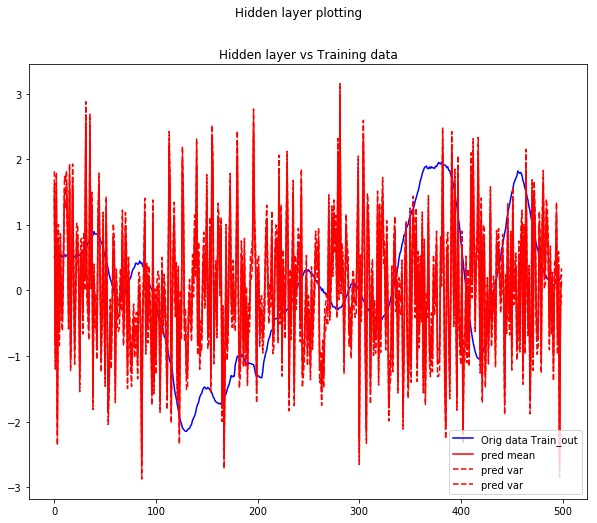

In [25]:
# Plot initialization of hidden layer:
def plot_hidden_states(layer, layer_start_point=None, layer_end_point=None,
                              data_start_point=None, data_end_point=None):
    if layer_start_point is None: layer_start_point=0;
    if layer_end_point is None: layer_end_point = len(layer.mean)
    
    if data_start_point is None: data_start_point=0;
    if data_end_point is None: layer_end_point = len(out_train)
        
    data = out_train[data_start_point:data_end_point]
    layer_means = layer.mean[layer_start_point:layer_end_point]
    layer_vars = layer.variance[layer_start_point:layer_end_point]

    fig4 = plt.figure(10,figsize=(10,8))
    ax1 = plt.subplot(1,1,1)
    fig4.suptitle('Hidden layer plotting')
    ax1.plot(out_train[data_start_point:data_end_point], label="Orig data Train_out", color = 'b')
    ax1.plot( layer_means, label = 'pred mean', color = 'r' )
    ax1.plot( layer_means +\
                     2*np.sqrt( layer_vars ), label = 'pred var', color='r', linestyle='--' )
    ax1.plot( layer_means -\
                     2*np.sqrt( layer_vars ), label = 'pred var', color='r', linestyle='--' )
    ax1.legend(loc=4)        
    ax1.set_title('Hidden layer vs Training data')

    del ax1

plot_hidden_states(m.layer_1.qX_0)

### Model training:

In [26]:
#init_runs = 50 if out_train.shape[0]<1000 else 100
init_runs = 100
print("Init runs:  ", init_runs)
m.optimize('bfgs',messages=1,max_iters=init_runs)
for i in range(m.nLayers):
    m.layers[i].kern.variance.constrain_positive(warning=False)
    m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=10000)

print(m)

Init runs:   100
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    02s28  008   1.657666e+03   6.119862e+05 
    04s46  018  -2.838268e+02   4.975744e+03 
    07s92  033  -4.172889e+02   1.338206e+02 
    10s06  043  -4.363057e+02   4.321317e+01 
    19s73  088  -4.682940e+02   1.731988e+01 
    22s58  102  -4.704225e+02   7.397856e+01 
Runtime:     22s58
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        

    02s14  00009  -7.473451e+02   1.319839e+03 
    07s49  00034  -8.754591e+02   6.905658e+02 
    22s58  00104  -9.500699e+02   1.230937e+03 
    33s23  00144  -9.665516e+02           nan  

 /Users/grigoral/work/code/paramz/build/lib/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:invalid value encountered in less


    33s48  00146  -9.665516e+02   1.995894e+04 
Runtime:     33s48
Optimization status: Converged


Name : autoreg
Objective : -966.55164783
Number of Parameters : 4064
Number of Optimization Parameters : 4064
Updates : True
Parameters:
  autoreg.                         |              value  |  constraints  |  priors
  layer_1.inducing_inputs          |           (50, 40)  |               |        
  layer_1.rbf.variance             |       10.109268222  |      +ve      |        
  layer_1.rbf.inv_lengthscale      |              (40,)  |      +ve      |        
  layer_1.Gaussian_noise.variance  |   0.00743736139958  |      +ve      |        
  layer_1.qX_0.mean                |           (500, 1)  |               |        
  layer_1.qX_0.variance            |           (500, 1)  |      +ve      |        
  layer_0.inducing_inputs          |           (50, 20)  |               |        
  layer_0.rbf.variance             |      9.31502024666  |      +ve      |        
  layer_0.rbf.in

### Look at trained parameters

In [27]:
if hasattr(m, 'layer_1'):
    print("Layer 1:  ")
    print("States means (min and max), shapes:  ", m.layer_1.qX_0.mean.min(), 
          m.layer_1.qX_0.mean.max(), m.layer_1.qX_0.mean.shape)
    print("States variances (min and max), shapes:  ", m.layer_1.qX_0.variance.min(), 
          m.layer_1.qX_0.variance.max(), m.layer_1.qX_0.mean.shape)
    print("Inverse langthscales (min and max), shapes:  ", m.layer_1.rbf.inv_lengthscale.min(),
          m.layer_1.rbf.inv_lengthscale.max(), m.layer_1.rbf.inv_lengthscale.shape )
    
if hasattr(m, 'layer_0'):
    print("")
    print("Layer 0 (output):  ")
    print("Inverse langthscales (min and max), shapes:  ", m.layer_0.rbf.inv_lengthscale.min(),
          m.layer_0.rbf.inv_lengthscale.max(), m.layer_0.rbf.inv_lengthscale.shape )

Layer 1:  
States means (min and max), shapes:   -4.95364344477 5.84222477644 (500, 1)
States variances (min and max), shapes:   0.00226724822157 0.913198814789 (500, 1)
Inverse langthscales (min and max), shapes:   1.41925168835e-06 0.0141379706292 (40,)

Layer 0 (output):  
Inverse langthscales (min and max), shapes:   4.49959175387e-08 0.000288126192473 (20,)


In [28]:
print(m.layer_0.rbf.inv_lengthscale)

  index  |  autoreg.layer_0.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.00000499  |      +ve      |        
  [1]    |                           0.00000670  |      +ve      |        
  [2]    |                           0.00000255  |      +ve      |        
  [3]    |                           0.00000289  |      +ve      |        
  [4]    |                           0.00000315  |      +ve      |        
  [5]    |                           0.00000296  |      +ve      |        
  [6]    |                           0.00002852  |      +ve      |        
  [7]    |                           0.00000120  |      +ve      |        
  [8]    |                           0.00000034  |      +ve      |        
  [9]    |                           0.00000066  |      +ve      |        
  [10]   |                           0.00000148  |      +ve      |        
  [11]   |                           0.00000930  |      +ve      |        
  [12]   |               

In [29]:
print(m.layer_1.rbf.inv_lengthscale)

  index  |  autoreg.layer_1.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.00000205  |      +ve      |        
  [1]    |                           0.00000547  |      +ve      |        
  [2]    |                           0.00001159  |      +ve      |        
  [3]    |                           0.00001047  |      +ve      |        
  [4]    |                           0.00001559  |      +ve      |        
  [5]    |                           0.00000821  |      +ve      |        
  [6]    |                           0.00000805  |      +ve      |        
  [7]    |                           0.00000784  |      +ve      |        
  [8]    |                           0.00000750  |      +ve      |        
  [9]    |                           0.00000909  |      +ve      |        
  [10]   |                           0.00001092  |      +ve      |        
  [11]   |                           0.00001135  |      +ve      |        
  [12]   |               

### Analyze and plot model on test data:

In [30]:
# Free-run on the train data
init_Xs = [None, m.layer_1.qX_0[0:win_out]] # init_Xs for train prediction
predictions_train = m.freerun(init_Xs = init_Xs, U=in_train, m_match=True)

# Free-run on the test data
init_Xs = [None, m.layer_1.qX_0[-win_out:] ] # init_Xs for test prediction
U_test = np.vstack( (in_train[-win_in:], in_test) )
predictions_test = m.freerun(init_Xs = init_Xs, U=U_test, m_match=True)
del init_Xs, U_test

Train overall RMSE:  [2.5202102591541058]
Test overall RMSE:  [1.8635626954178819]


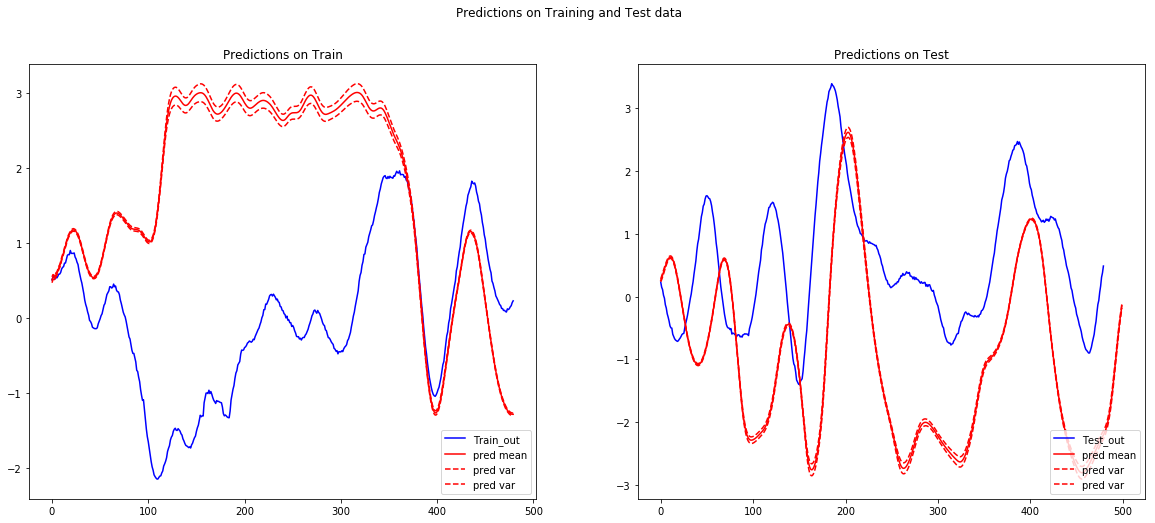

In [31]:
# Plot predictions
def plot_predictions(posterior_train, posterior_test=None, layer_no = None):
    """
    Plots the output data along with posterior of the layer.
    Used for plotting the hidden states or
    
    layer_no: int or Normal posterior
        plot states of this layer (0-th is output). There is also some logic about compting
        the MSE, and aligning with actual data.
    """
    
    if layer_no is None: #default
        layer_no = 1

    if posterior_test is None:
        no_test_data = True
    else:
        no_test_data = False

    if isinstance(posterior_train, list): 
        layer_in_list = len(predictions_train)-1-layer_no # standard layer no (like in printing the model)
        predictions_train_layer = predictions_train[layer_in_list]
    else:
        predictions_train_layer = posterior_train

    if not no_test_data:
        if isinstance(posterior_test, list): 
            predictions_test_layer = predictions_test[layer_in_list]
        else:
            predictions_test_layer = posterior_test


    if layer_no == 0:
        pred_ind_start=0; orig_data_ind_start=win_out 
    else:
        pred_ind_start=0; orig_data_ind_start=0 

    if layer_no == 0:
        # Compute RMSE ignoring first output values of length "win_out"
        train_rmse = [comp_RMSE(predictions_train_layer.mean[pred_ind_start+win_out:],
                                out_train[orig_data_ind_start+win_out:])]
        print("Train overall RMSE: ", str(train_rmse))
        
        if not no_test_data:
            # Compute RMSE ignoring first output values of length "win_out"
            try:
                test_rmse = [comp_RMSE(predictions_test_layer.mean[pred_ind_start+win_out:],
                                       out_test[orig_data_ind_start+win_out:])]
            except ValueError as ee: # length of predicted and test are equal. When we start from previous.
                test_rmse = [comp_RMSE(predictions_test_layer.mean[pred_ind_start+win_out:],
                                       out_test[-win_out + orig_data_ind_start+win_out:])]
            print("Test overall RMSE: ", str(test_rmse))
    
    
    # Plot predictions:
    if not no_test_data:
        fig5 = plt.figure(10,figsize=(20,8))
    else:
        fig5 = plt.figure(10,figsize=(10,8))
        
    fig5.suptitle('Predictions on Training and Test data')
    if not no_test_data:
        ax1 = plt.subplot(1,2,1)
    else:
        ax1 = plt.subplot(1,1,1)
    ax1.plot(out_train[orig_data_ind_start:], label="Train_out", color = 'b')
    ax1.plot( predictions_train_layer.mean, label = 'pred mean', color = 'r' )
    ax1.plot( predictions_train_layer.mean +\
                     2*np.sqrt( predictions_train_layer.variance ), label = 'pred var', color='r', linestyle='--' )
    ax1.plot( predictions_train_layer.mean -\
                     2*np.sqrt( predictions_train_layer.variance ), label = 'pred var', color='r', linestyle='--' )
    ax1.legend(loc=4)        
    ax1.set_title('Predictions on Train')

    if not no_test_data:
        ax2 = plt.subplot(1,2,2)
        ax2.plot(out_test[orig_data_ind_start:], label="Test_out", color = 'b')

        ax2.plot( predictions_test_layer.mean, label = 'pred mean', color = 'r' )
        ax2.plot( predictions_test_layer.mean +\
                         2*np.sqrt( predictions_test_layer.variance ), label = 'pred var', color='r', linestyle='--' )
        ax2.plot( predictions_test_layer.mean -\
                         2*np.sqrt( predictions_test_layer.variance ), label = 'pred var', color='r', linestyle='--' )
        ax2.legend(loc=4)        
        ax2.set_title('Predictions on Test')

        del ax2
    del ax1
plot_predictions(predictions_train, predictions_test , layer_no = 0)

In [32]:
predictions_test[-1].mean.shape


(500, 1)

In [33]:
comp_RMSE(np.zeros( (len(out_train[20:]),1) ), out_train[20:] )

1.0149858027186212

In [34]:
out_train[20:].mean(0)

array([-0.02185332])

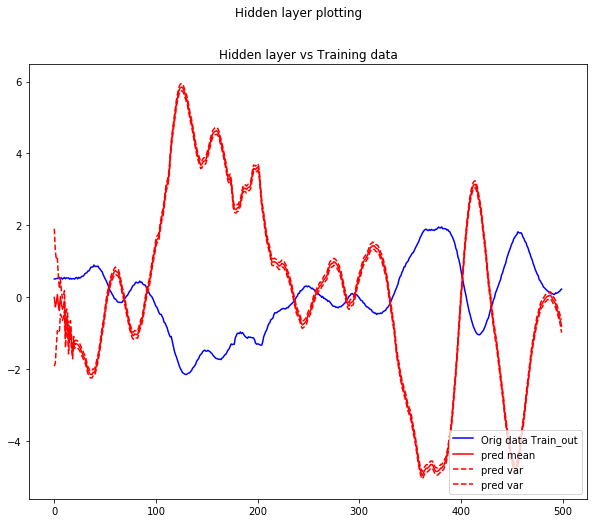

In [35]:
plot_hidden_states(m.layer_1.qX_0)